# Analysis of IFSC Bouldering Competitions 2007 - 2022

In [72]:
import importlib
import os
import warnings

import itables
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
import scipy.spatial

import plotly 
import plotly.io 
import plotly.subplots
import plotly.graph_objs as go
import plotly.express as px

import plot
# importlib.reload(plot)

<module 'plot' from '/media/Volume/David/Repos/ifsc-analysis/plot.py'>

In [87]:
from IPython.core.display import HTML
HTML("""
<style>
    #notebook-container {
    width: 80% !important;
}
.dataTable {
    width: 100% !important;
}
.output_html {
    max-width: calc(100%) !important;
}
.rendered{
    font-size: 125%;
}
</style>
""")

In [74]:
# show tables in notebook
itables.init_notebook_mode(all_interactive=True)
itables.options.maxBytes = 1e6

# set figure template and size
template = "plotly_white"
fwidth = 1200
fheight = 800

# define bouldering results columns
scb = ["Top1", "Zone1", "Top2", "Zone2", "Top3", "Zone3", "Top4", "Zone4", "Top5", "Zone5"]

# set medal colors (gold, silver, bronze)
colorl = ['lightgray', 'gray', "black"]

# ignore warning
warnings.filterwarnings("ignore")

# remove unnecessary control items in figures
config = {
    'modeBarButtonsToRemove': ['zoomIn', 'zoomOut', 'resetScale2d', 'select2d', 'lasso2d'],
    'responsive': True,
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg',  # one of png, svg, jpeg, webp
        'filename': 'ifsc-analysis',
        'width': fwidth,
        'height': fheight,        
        'scale': 1
      }
}

<IPython.core.display.Javascript object>

In [75]:
# load data
fin = pd.read_excel("ifsc.xlsx")

# extract more structured competition infos
compz = fin["Competition"].unique()
rep = {comp: comp.split("IFSC")[0].strip().replace(" • ", " ") 
       for comp in compz}
fin["Disc"] = fin["Competition"].map(rep)
rep = {comp: comp.replace("IFSC -", "IFSC").split("IFSC")[1].split(" - ")[0].split("(")[0].strip() 
       for comp in compz}
fin["Type"] = fin["Competition"].map(rep)    
rep = {comp: comp.replace("IFSC -", "IFSC").split("IFSC")[1].split(" - ")[1].split("(")[0].strip() 
       for comp in compz}          
fin["City"] = fin["Competition"].map(rep)   
rep = {comp: comp.replace("IFSC -", "IFSC").replace("Europe -", "").replace("Moscow 2021", "Moscow (RUS) 2021").split("IFSC")[1].split(" - ")[1].split("(")[-1][:3].strip() 
       for comp in compz}
fin["Loca"] = fin["Competition"].map(rep)  
rep = {comp: plot.month2number(comp.split(" ")[-1]) + '-' + comp.split(" ")[-2].zfill(2) 
       if comp.split(" ")[-3] == '-' 
       else plot.month2number(comp.split(" ")[-1]) + '-' + comp.split(" ")[-4].zfill(2) 
       for comp in compz}
fin["Time"] = fin["Competition"].map(rep)
fin["Date"] = fin["Year"].astype(str) + '-' + fin["Time"]
fin["Comp"] = fin["Date"].astype(str) + " " + fin["City"]

# format and unify other columns
fin["Number"] = [str(val).zfill(3) for val in fin["Number"]]
fin["Place"] = [sum(uni == fin["Unique"][:idu])+1 for idu, uni in enumerate(fin["Unique"])]
fin["Name"] = [str(val).lower() for val in fin["Name"]]

# compute active period of climbers
fia = fin.groupby("Name").agg({'Year': ["min", "max"]})
fin["Active"] = ['%s-%s' % tuple(fia.loc[name, [("Year", "min"), ("Year", "max")]]) for name in fin["Name"]]

# define variable sets
names = np.unique(fin["Name"])
countries = np.unique(fin["Country"])
levels = ["Q", "S", "F"]
genders = np.unique(fin["Gender"])
numbers = np.unique(fin["Number"])
uniques = np.unique(fin["Unique"])
years = np.unique(fin["Year"])

## Introduction - Starting point and goals

Climbing is fun! 
Since 2007 the International Federation of Sport Climbing (<a href="https://www.ifsc-climbing.org/">IFSC</a>) organizes competitive sport climbing events.
These events cover the disciplines of lead climbing, speed climbing, and bouldering (as well as a combined format).

Here, we focus on and analyze the available data of all IFSC bouldering competitions. 
Who were and are the strongest competition climbers of their time? 
Can we find climbing styles by correlating who climbed similar boulders? 
Who is able to climb through qualification, semi-finals, and finals without falling off the wall? 
Which competitions were the hardest?

## Preparation - Getting and analyzing quantitative and detailed data

Thankfully, the IFSC provides a comprehensive and accessible archive of competition data on the <a href="https://ifsc.results.info">IFSC info site</a>. 
These data cover all IFSC bouldering events between 2007 and now, including qualifiation, semi-final, and final results for World Cups and World Championships.
For events after 2007, all participants' attempts to zone and attempts to top are indicated as well as their ranking in the competition.

To automate data acquisition, we use a Python Selenium script which is provided in our <a href="https://github.com/DavidBreuer/ifsc-analysis">GitHub repository</a>.
Data are compiled into a comprehensive Excel table which is used for subsequent analyses.
Since climbers' names in the original data showed inconsistent capitalization, we change them to lowercase for simplicity.

Our analyses are performed using Python and published here as <a href="https://DavidBreuer.github.io/ifsc-analysis">GitHub Pages</a>. 
For example, we cover athlete statistics, for individual years and overall aggregates, a visualization of similarities in topped boulders between climbers, as well as competition statistics.

Please feel free to use these data analyses, contribute to our repository, and have fun gaining new climbing insights!

## Analysis - Competition statistics for all climbers over recorded period

To start with, we compile a table of competition statistics by counting the number and fraction of participations in different competition rounds for each of the 2000+ climbers.
Here and in the following we refer to absolute counts (#) and percentages (%) relative to the total number of competition participations.
Moreover, we refer to qualification rounds (Q), semi-finals (S), finals (F), podium (P), third (3), second (2), and first places (1), respectively.

Please click on a column header in the table to sort accordingly or use the search bar to filter for specific climbers.

The initial table view is sorted by the number of podium places (#P) which shows Akiyo Noguchi at the top with an impressive 60. 
Alternatively, sorting by the percentage of first places (%1) shows that an incredible Janja Gargret won 70% of all IFSC bouldering competitions she entered.

In [76]:
# aggregate competition statistics
podiums = plot.results_2_podiums(fin)

# pre-sort by number of podium places
tab = podiums.sort_values("#P", ascending=False)

# show sortable and searchable table
itables.show(tab.reset_index(drop=True).round(decimals=2))

## Analysis - Final participations of top climbers over time

The previous statistics were aggregated across the whole recorded period. Now, we additionally visualize the number of finals (#F) per climber and year. For better visibility we show only athletes who participated in more than 3 finals. Additionally, we sort the figure by the climbers' highpoints in time (average of years weighted by number of finals).

The figure clearly shows a gradual shift when some climbers become stronger, stop competing eventually, and are a followed by new generations. We can also identify climbers who made finals in few years as compared to others who dominated the scene over long periods. Here, again, Akiyo Noguchi stands out with consistent final participation from 2007 up to her retirement from IFSC competitions in 2021.

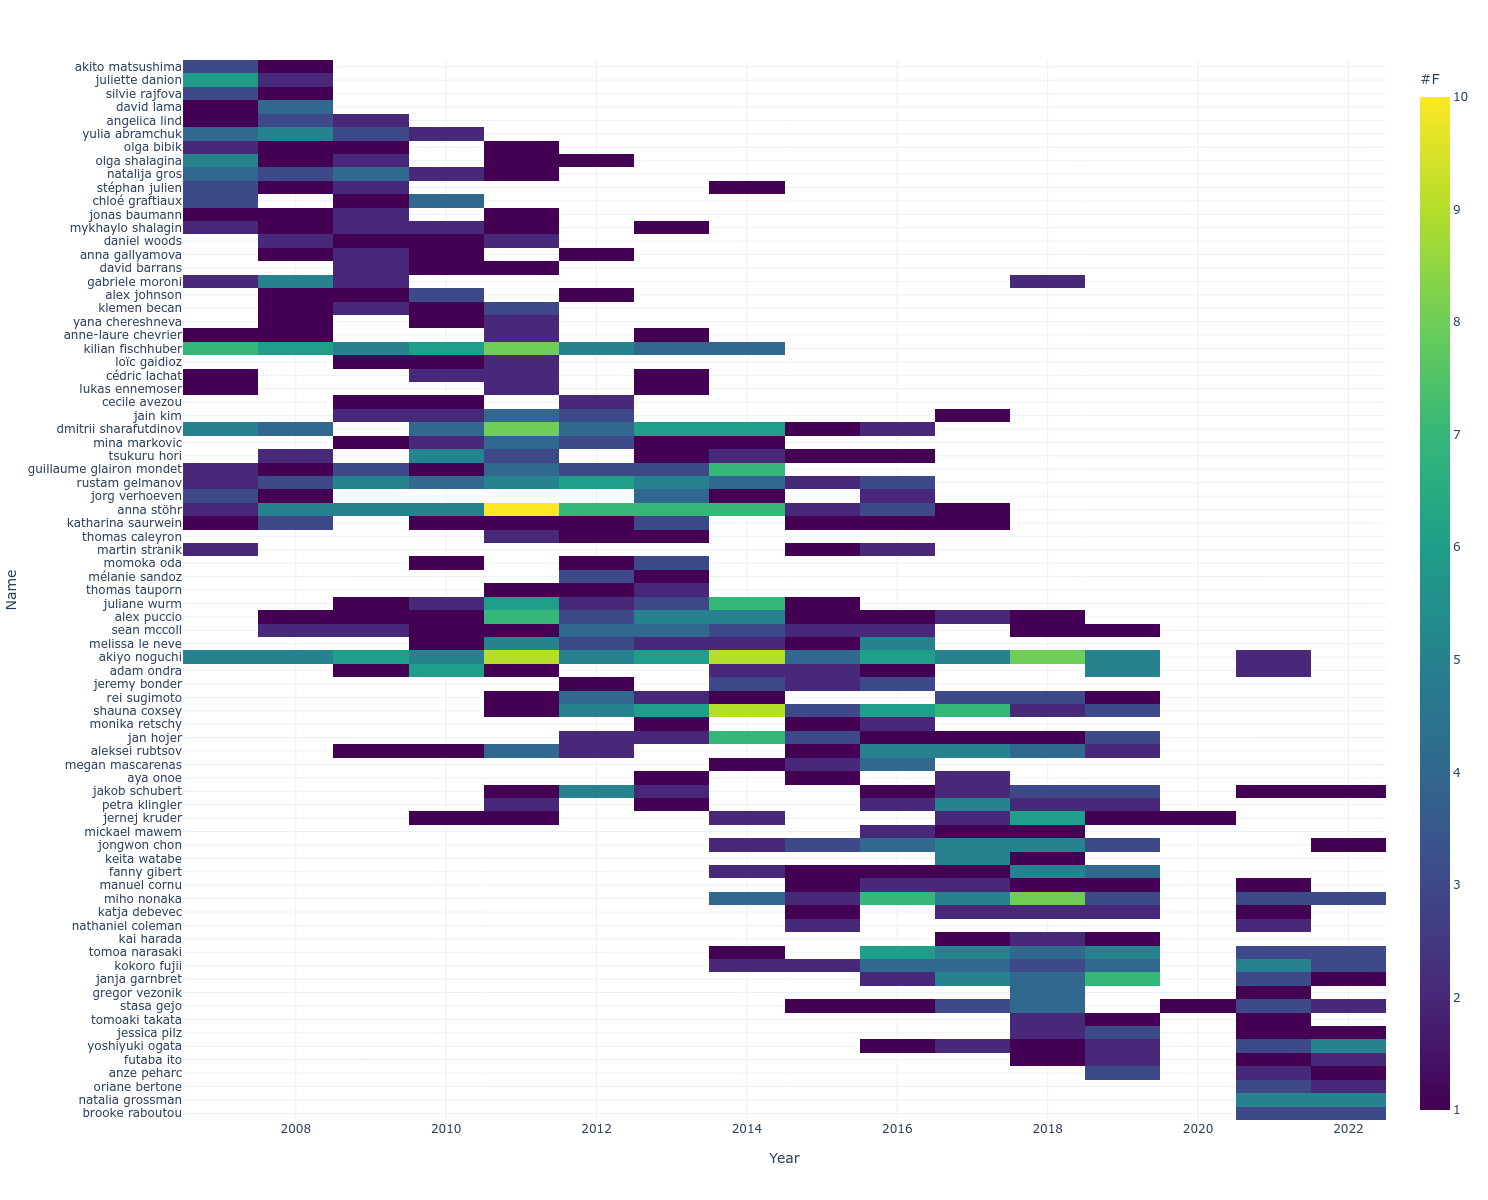

In [77]:
# find climbers with more than three finals
sub = fin[fin["Level"]=="F"]
whr = sub.groupby("Name", as_index=False).count()
namez = np.unique(whr.loc[whr["Unique"]>3, "Name"])

# count number of finals per climber and year
dat = pd.DataFrame(np.nan, columns=years, index=namez)
grp = sub[sub["Name"].isin(namez)].groupby(["Name", "Year"], as_index=False).count()
for idr, row in grp.iterrows():
    dat.loc[row["Name"], row["Year"]] = row["Unique"]
srt = ((dat * dat.columns).mean(1)/dat.mean(1)).argsort()

# show heatmap
fig = px.imshow(dat.iloc[srt],
                template=template,
                color_continuous_scale="Viridis",
                labels={"x": "Year",  "y": "Name", "color": "#F"},
                width=fwidth, height=1.5*fheight
                )

fig.update_yaxes(
    tickmode="linear"
)

fig.show(config=config)

## Analysis - Detailed event participations of top climbers over time

Next, we dive one step deeper. We count the number of participations in different competitions rounds over the years. We focus on the same set of climbers with more than 3 finals as before.

Use the dropdown menu in the figure to choose between the aggregation of all climbers' and individual results. Here, we highlight the young and astonishing career of Natalia Grossman, who participated in a handful of IFSC competitions before and burst onto the scene in 2021, making finals in every competition she joined since.

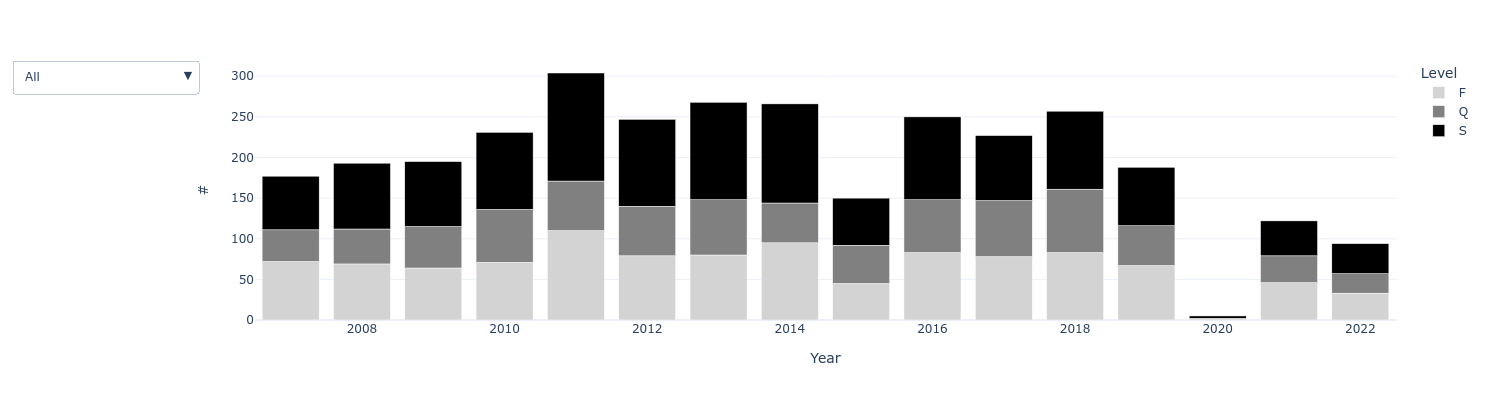

In [78]:
# count number of participations per round and name and climber
groups = fin.groupby(["Level", "Name", "Year"])
dats = []
for name in namez:
    dat = pd.DataFrame(0, columns=years, index=levels[::-1])    
    dat["Name"] = name    
    for year in years:        
        id1 = plot.get_group(groups, ("F", name, year))
        id2 = plot.get_group(groups, ("S", name, year)) 
        id3 = plot.get_group(groups, ("Q", name, year)) 
        dat.loc["F", year] = len(id1)
        dat.loc["S", year] = len(id2)-len(id1)
        dat.loc["Q", year] = len(id3)-len(id2)        
    dat["Level"] = levels[::-1]
    dats.append(dat)    
dat = pd.concat(dats)
daf = dat.melt(id_vars=["Name", "Level"], var_name="Year", value_name="#")

# show bar plot (ALL = sum of climbers' results)
dan = daf[daf["Name"].isin(names)].groupby(["Level", "Year"], as_index=False).sum()
fig = px.bar(x=dan["Year"], y=dan["#"], color=dan['Level'], orientation='v',
             height=400,
             color_discrete_sequence=colorl,
             template=template,
             labels={"x": "Year",  "y": "#", "color": "Level"},
             )

# (indvidual results per climber)
lst = [{
    'method': 'update',
    'label': 'All',
    'args': [{'y': [dan[dan["Level"]==lev]["#"].values for lev in levels[::-1]]}] 
}]
for name in namez:  
    idn = daf["Name"].isin([name])
    dan = daf[idn]
    lst += [
        {
        'method': 'update',
        'label': name,
        'args': [{'y': [dan[dan["Level"]==lev]["#"].values for lev in levels[::-1]]}] 
    }]
    
# add dropdown menu to figure   
updatemenus = [{
    'buttons': lst,
    'direction': 'down',
    'showactive': True,
    }]
fig = fig.update_layout(updatemenus=updatemenus)

fig.show(config=config)

## Analysis - Similarity of topped boulders between climbers

Due to the detailed competition data, we can even compare how similar different climbers perform in competitions and even individual boulder problems. To that end, we calculate the similiarity between two athletes as the fraction of identical boulders that they topped (between 0-100%). This yields a graph or network, where each climber is a represented by a node and the similarity is reflected by the edge width. To identify clusters of similar climbers, we keep only the 10% of edges with highest similarity scores. 

Use the dropdown in the network visualization below to choose between men and women and years. The node/climber color indicates the number of podiums and the mouse-over tooltip shows additional climber statistics. The edge width reflects the similarity score between the two climbers in question and the mouse-over tooltip shows the boulders that were topped (1), not topped (0), or not attempted (-). (Info: The initially presented network is for 2022-W although the dropdown menu shows the first entry.)

Consequently, there are many networks to study. Here, we focus only on 2021-W and find two clusters of climbers, i.e. groups of climbers who topped similar sets of boulders. The first, small cluster includes Camila Moroni and Elena Krasovskaia. The second, larger cluster includes 10 athletes, most similar among them are Janja Garnbret and Natalia Grossmann who were the only ones able to climb all the hardest boulders.

Annotating different boulders with their styles (e.g. more static or dynamic, slabby or overhanging, slopy or juggy) might provide more informative interpretations for the found similiary clusters but is beyond of our current scope.

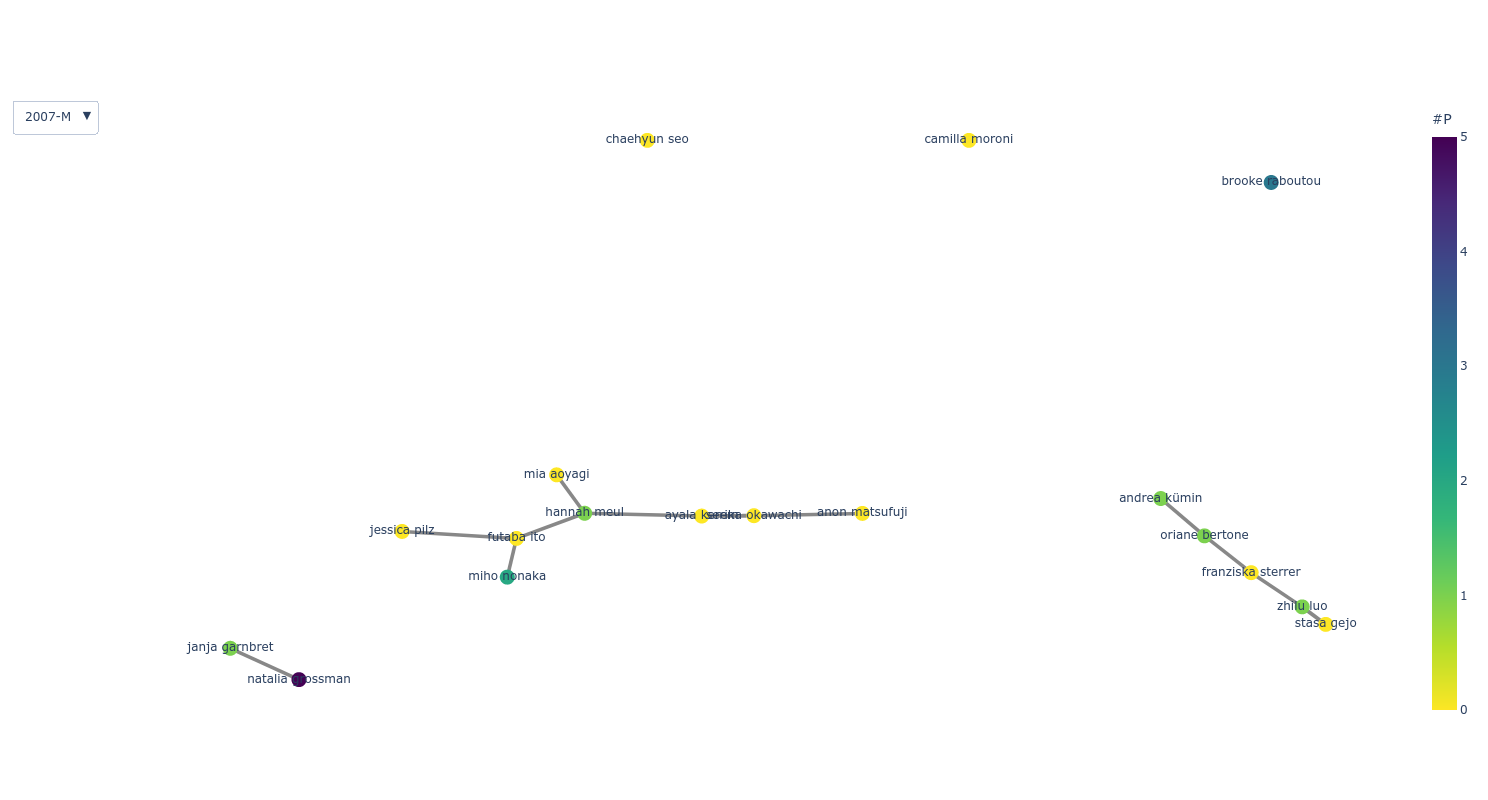

In [84]:
# loop over years and genders
importlib.reload(plot)
lst = []
boos = dict()
datas = []
groups = fin.groupby(["Year", "Gender"])
for year in years:    
    for gender in genders: 

        # pick only finalists
        group = groups.get_group((year, gender))
        pod = plot.results_2_podiums(group)
        nameg = group.loc[group["Level"] == "F", "Name"]             
        sub = group[group["Name"].isin(nameg)]               

        # generate similarity graph for selected climbers
        graph, pos, labels, pivot = plot.sub_2_graph(sub, scb, percentile=10)       
        
        # compile table with climbers' infos in similarity network (name, node position, competition results, tooltip)
        pod = pod[pod.index.isin(labels.values())]
        pod["Name"] = pod.index
        pod["x"] = [poi[0] for poi in pos.values()]
        pod["y"] = [poi[1] for poi in pos.values()]
        pod["pattern"] = [''.join([str(val)[0] for val in pivot.loc[non].values]).replace("n", "-") for non in pod["Name"]]
        pod["t"] = ["<b>%s</b><br>#P: %s<br>#F: %s<br>#S: %s<br>#Q: %s" % (row["Name"], row["#P"], row["#F"], row["#S"], row["#Q"]) 
                    for idr, row in pod.iterrows()]

        # initially show results for 2022 women's competitions
        vis = (year == 2021) & (gender == "W")
               
        # prepare network data
        fig, boo, data = plot.networkx_2_plotly(graph, pos, pod, template, fwidth, fheight, vis=vis)        
        datas += data            
        label = str(year) + '-' + gender
        boos[label] = boo
        
# generate dropdown menu for years and genders
for year in years:    
    for gender in genders: 
        label = str(year) + '-' + gender
        booc = boos.copy()
        booc[label] = [True] * len(booc[label])        
        visi = list(np.hstack(booc.values()))
        lst += [{
            'method': 'restyle',
            'label': label,
            'args': [{'visible': visi}]
        }]
    
updatemenus = [{
    'buttons': lst,
    'direction': 'down',
    'showactive': True,
    }]

# show network visualization
fig = go.Figure(data=datas,    
                layout=go.Layout(
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    hoverlabel=dict(font=dict(family='monospace')),
                    template=template,
                    height=fheight, width=fwidth,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
                )

fig = fig.update_layout(updatemenus=updatemenus)

fig.show(config=config)

## Analysis - Fully topped competitions with lowest numbers of falls  

Topping a boulder in the first attempt, without falling once, is called a flash. Here, we count the number of falls per competation and climber. Clearly, this number is only well-defined for the best climbers who could top all boulder problems in all rounds a a given competition. Otherwise, the number of falls is not comparable or meaningful and is therefore omitted.

The heatmap color indicates the number of falls per climber and competition. Use the mouse-over to get more readable infos about the respective color point. 

To start with, we note that the available data provide the numbers of attempts only after 2007 (see horizontal lines). Next, we see the sparse color points, showing that only few athletes ever managed to top all boulders in a competition. Notably, again, Janja Garnet achieved to top all boulders in 9 of her competitions!

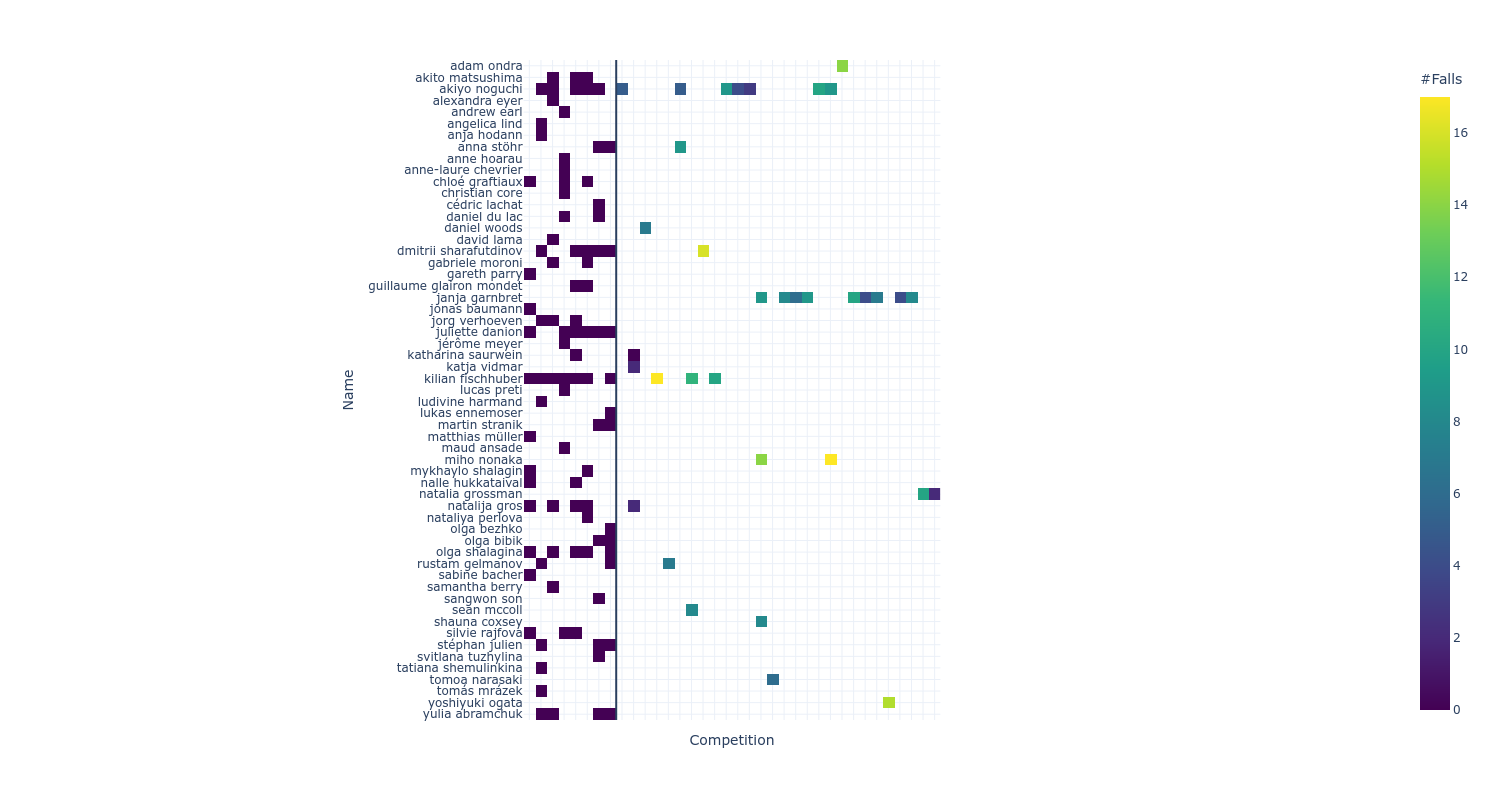

In [80]:
# group data by climber and competition
groups = fin[fin["Name"].isin(names)].groupby(["Name", "Competition"])

# compute number of falls (only well-defined if all boulder problems in all competitions rounds have been topped)
tab = pd.DataFrame(np.nan, index=names, columns=fin["Competition"].unique())
for (idn, idc), group in groups:
    if "F" in list(group["Level"]):
        tab.loc[idn, idc] = (group.loc[:, scb[::2]]-1).replace(np.nan, 0).sum().sum()
tab.replace(np.inf, np.nan, inplace=True)
tab.dropna(how="all", axis=0, inplace=True)
tab.dropna(how="all", axis=1, inplace=True)
    
# show heatmap
fig = px.imshow(tab,
                template=template,
                color_continuous_scale="Viridis",
                labels={"x": "Competition",  "y": "Name", "color": "#Falls"},
                width=fwidth, height=fheight
                )

# indicate change in IFSC data provisioning in 2008 by vertical line
xline = [idi for idi, col in enumerate(tab.columns) if '2008' in col][0]-0.5
fig.add_vline(x=xline)

fig.update_yaxes(
    tickmode="linear"
)

lenc = len(tab.columns)
fig.update_xaxes(
    tickmode = 'array',
    tickvals = list(range(lenc)),
    ticktext = ['']*lenc
)

fig.show(config=config)

## Analysis - Competition difficulty over time and across countries

Finally, we turn away from individual climbers' statistics and towards a short analysis of different competitions. As a simple measure of competition difficulty, we calculate the average fraction of tops across all boulders and climbers. More difficult competitions come with a lower rate of tops.

The heatmaps display the competition difficult aggregated per year (top panel), per hosting country (middle panel), and non-aggregated (bottom panel). During most competitions, the rate of tops is between 30-50% (first and third quartile). However, there are deviations, for example the first 2022 Worldcup in Salt Lake City had a top rate as high as 77%. In contrast, the 2019 World Championship finals were hard with only 23% tops.

In the non-aggreated heatmap, we additionally provide average top rates per competition round. They support the general obervation that qualifiation rounds (42%) are typically easier than semi-finals (39%), while finals frequently feature most tops (50%).

percentiles (25, 50, 75) [32.23214286 43.79807692 52.08333333]


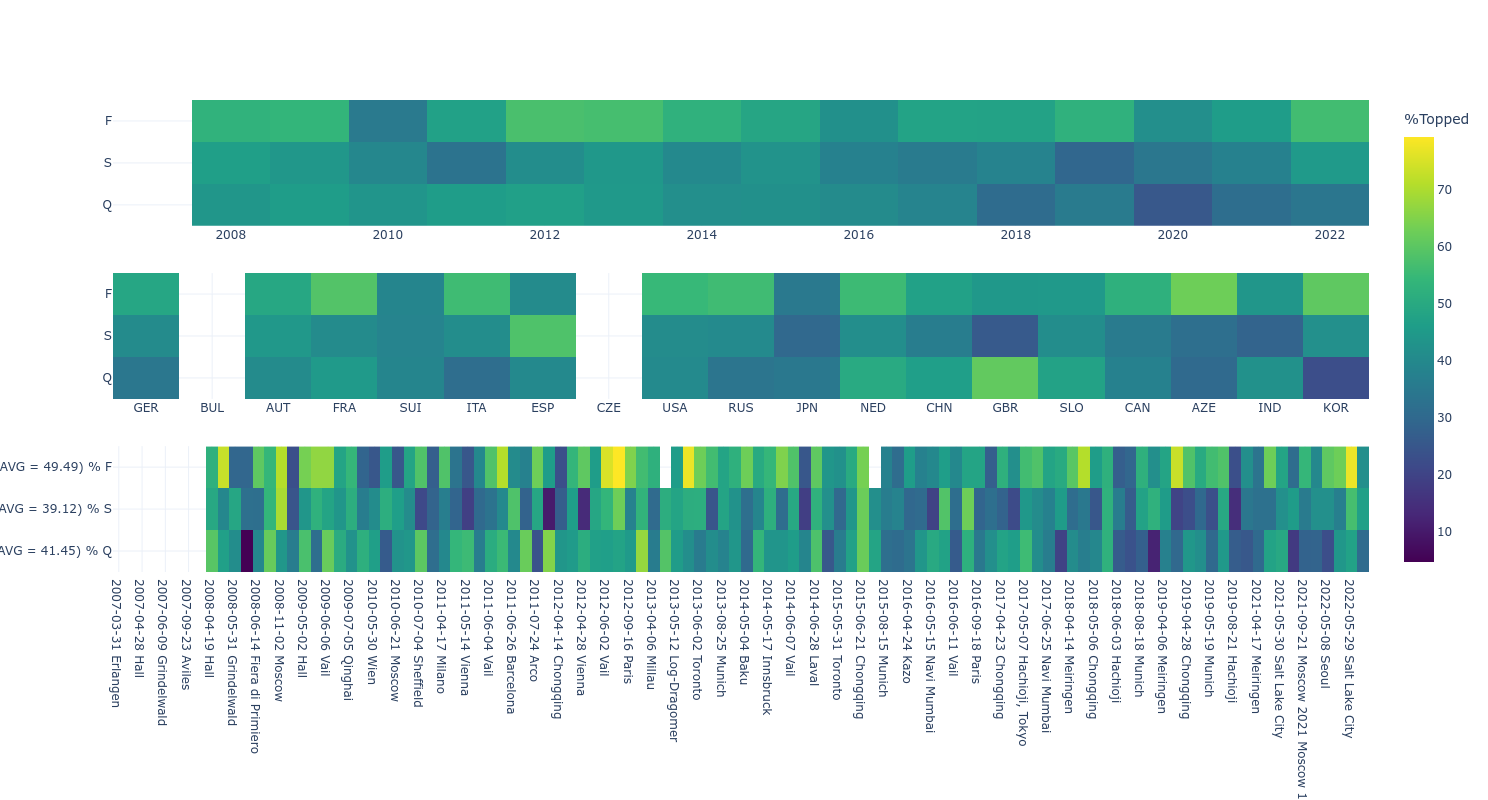

In [81]:
# compute percentages of topped boulders across competitions (aggregated by year, country, and non-aggregated)
levels = ["Q", "S", "F"]
figures = []
figures += [plot.plot_difficulty("Year", fin, names, scb, levels, template, fwidth, fheight)]
figures += [plot.plot_difficulty("Loca", fin, names, scb, levels, template, fwidth, fheight)]
figures += [plot.plot_difficulty("Comp", fin, names, scb, levels, template, fwidth, fheight)]

# show heatmaps
fig = plotly.subplots.make_subplots(rows=3, cols=1) 
for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)
fig.update_coloraxes(colorscale='Viridis', colorbar_title_text="%Topped")
fig.update_layout(template=template, width=fwidth, height=fheight)
fig.show(config=config)

## Conclusion - Thanks and future steps

Thanks for your time, we hope you had fun and enjoying some interesting results and climbing insights!

We'll update the current data set and analyses after the upcoming IFSC bouldering events.

Please feel free to re-use or contribute to our work as explained <a href="https://github.com/DavidBreuer/ifsc-analysis/blob/main/README.md">here</a>. 

See you on the wall and ¡Vamos! Gamba, Gamba! давай! Geht schon! Dai! Ajde! Kom igen! Allez, Allez, Allez! 